# Logistic Regression vs LDA vs QDA (with Decision Boundaries)

## Roadmap
1. **Warm-up: logistic regression under complete separation** — why MLE can fail, how regularization helps
2. **Logistic regression (Smarket, binary)**, **LDA (Smarket, binary)**, **QDA (Smarket, binary)**
3. **Multi-class comparison (Iris)** — softmax logistic vs LDA vs QDA decision regions
4. **Wrap-up summary**


In [1]:
!pip -q install ISLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import statsmodels.api as sm
from ISLP import load_data
from ISLP import confusion_table
from ISLP.models import (ModelSpec as MS,
summarize)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import load_iris

import statsmodels.api as sm
#from statsmodels.tools.sm_exceptions import PerfectSeparationError

plt.rcParams['figure.figsize'] = (7, 5)


## Warm-up: when logistic regression MLE *doesn't* converge (complete separation)

For binary logistic regression, the model is

$$
P(y=1\mid x)=\sigma(\beta_0+\beta^\top x),\qquad 
\sigma(t)=\frac{1}{1+e^{-t}}.
$$

The (unregularized) **maximum likelihood** estimate maximizes the log-likelihood

$$
\ell(\beta)=\sum_{i=1}^n \Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big],
\quad p_i=\sigma(\beta_0+\beta^\top x_i).
$$

If the classes are **completely separable** by some hyperplane, the log-likelihood can be increased arbitrarily by scaling a separating direction: as $\lVert\beta\rVert\to\infty$, the fitted probabilities move toward $0/1$ and $\ell(\beta)$ approaches its supremum. In practice, Newton–Raphson / IRLS fitting can become numerically unstable because the Hessian becomes ill-conditioned, so coefficient iterates may grow without bound.

Below we create a toy **separable** dataset and show that unregularized fitting can produce huge coefficients or warnings, while **regularization** yields a stable, finite solution.

In [2]:
np.random.seed(0)
y0=np.zeros(10)
y1=np.ones(10)
y = np.concatenate((y0, y1))
x0=np.random.normal(0, 1, 10) # this follows Normal(0,1)
x1=np.random.normal(5, 1, 10) # this follows Normal(5,1) to set x0 and x1 far from each other
x = np.concatenate((x0 , x1 ))
df = pd.DataFrame({'x': x})
design = MS(df)
X = design.fit_transform(df)
glm = sm.GLM(y, #Fit logistic regression
X,
family=sm.families.Binomial())
results = glm.fit()
#summarize(results)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8801e-09
Date:                Thu, 26 Feb 2026   Deviance:                   3.7601e-09
Time:                        13:57:41   Pearson chi2:                 1.88e-09
No. Iterations:                    23   Pseudo R-squ. (CS):             0.7500
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -69.6783   4.88e+04     -0.001      0.9

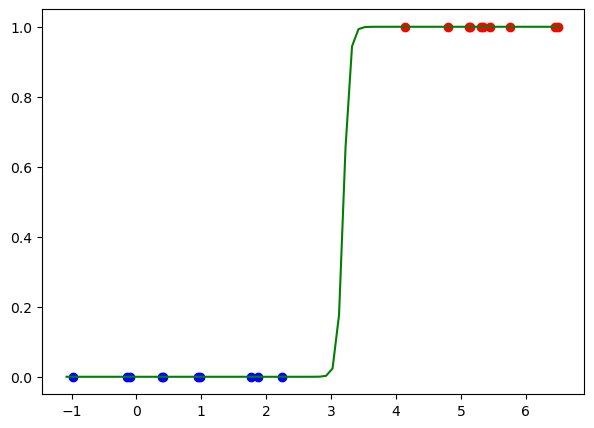

In [3]:
# Plot x0 and y0 with blue points
plt.scatter(x0, y0, color='blue', label='x0, y0', zorder=5)
# Plot x1 and y1 with red points
plt.scatter(x1, y1, color='red', label='x1, y1', zorder=5)
# Generate sequence for smooth curve
seq = pd.DataFrame({'x': np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)})
sequence = design.transform(seq)
prediction_line=results.predict(sequence)

plt.plot(seq, prediction_line, color='green', label='Prediction', zorder=10)
# Show model summary
print(results.summary())

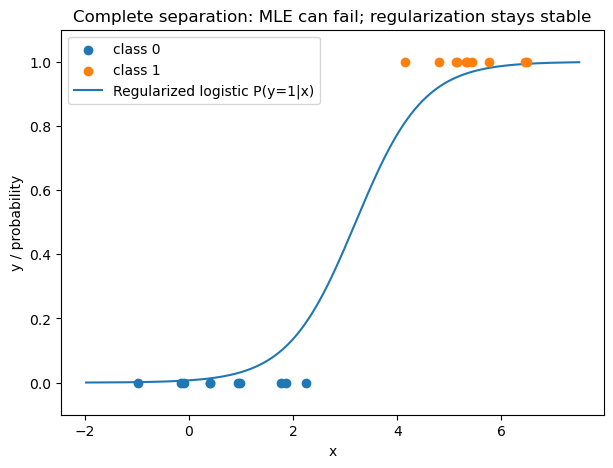

Regularized coefficients: -4.926105529156162 1.5394481836906566


In [4]:
# Regularized logistic regression (scikit-learn uses L2 by default)
X_skl = x.reshape(-1, 1)
clf_reg = LogisticRegression(C=1.0, solver="lbfgs")
clf_reg.fit(X_skl, y)

# Plot points + regularized probability curve
xs = np.linspace(x.min()-1, x.max()+1, 400).reshape(-1, 1)
ps = clf_reg.predict_proba(xs)[:, 1]

plt.figure()
plt.scatter(x0, np.zeros_like(x0), label="class 0", zorder=3)
plt.scatter(x1, np.ones_like(x1), label="class 1", zorder=3)
plt.plot(xs[:, 0], ps, label="Regularized logistic P(y=1|x)")
plt.ylim(-0.1, 1.1)
plt.xlabel("x")
plt.ylabel("y / probability")
plt.title("Complete separation: MLE can fail; regularization stays stable")
plt.legend()
plt.show()

print("Regularized coefficients:", clf_reg.intercept_[0], clf_reg.coef_[0,0])


**Takeaway:**  
- With **complete separation**, *unregularized* logistic regression MLE may not exist (coefficients blow up).  
- In practice, packages often add **regularization**, which makes the optimization well-posed and produces a finite solution.  

Now we move to real data and compare **logistic regression vs LDA vs QDA**.


## Helper function: decision boundary / decision region plotting
We'll reuse a small helper that:
- makes a grid in feature space,
- predicts labels on the grid,
- draws a filled contour + the training points.


In [5]:
def plot_decision_boundary(model, X, y, title, xlabel='x1', ylabel='x2', grid_step=0.02):
    X = np.asarray(X)
    y = np.asarray(y)
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


## Dataset 1: Smarket (binary)
In this lab we will examine the Smarket data, which is part of the ISLP
library. This data set consists of percentage returns for the S&P 500 stock
index over 1,250 days, from the beginning of 2001 until the end of 2005.


For each date, we have recorded the percentage returns for each of the five
previous trading days, Lag1 through Lag5. We have also recorded Volume
(the number of shares traded on the previous day, in billions), Today (the
percentage return on the date in question) and Direction (whether the
market was Up or Down on this date).

In [6]:
Smarket = load_data('Smarket')
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [7]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


As one would expect, the correlations between the lagged return variables
and today's return are close to zero. The only substantial correlation is
between `Year` and `Volume`.

In [8]:
#To show correlations
Smarket.drop(columns='Direction').corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


By plotting the data we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

Text(0.5, 0, 'Days')

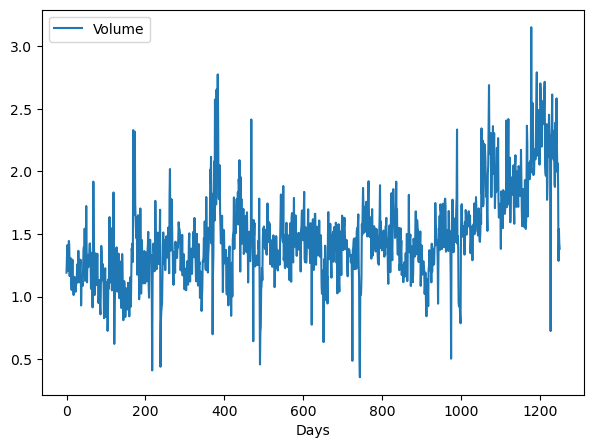

In [9]:
ax = Smarket.plot(y="Volume")
ax.set_xlabel("Days")

---
# 1) Logistic Regression
## Model (math)
Binary logistic regression models the posterior directly:

$$
P(y=1\mid x)=\sigma(\beta_0+\beta^\top x),\qquad \sigma(t)=\frac{1}{1+e^{-t}}.
$$

Decision rule (0/1):

$$
\hat y = \mathbb{1}\{\beta_0+\beta^\top x \ge 0\}.
$$

**Decision boundary:** $\beta_0+\beta^\top x = 0$ — a **line/hyperplane**.

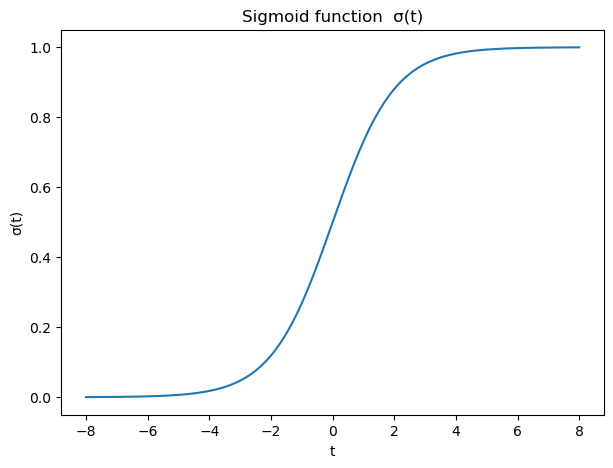

In [10]:
# Quick visual: the sigmoid
t = np.linspace(-8, 8, 400)
sig = 1/(1+np.exp(-t))
plt.figure()
plt.plot(t, sig)
plt.title('Sigmoid function  σ(t)')
plt.xlabel('t')
plt.ylabel('σ(t)')
plt.ylim(-0.05, 1.05)
plt.show()

Next, we will fit a logistic regression model in order to predict Direction using Lag1 through Lag5 and Volume. The sm.GLM() function fits generalized linear models, a class of models that includes logistic regression. The syntax of sm.GLM() is similar to that of sm.OLS(), except that we must pass in the argument family=sm.families.Binomial() in order to tell statsmodels to run a logistic regression rather than some other type of generalized linear model.

In [11]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
X,
family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The smallest p-value here is associated with `Lag1`. The negative coeffcient
for this predictor suggests that if the market had a positive return yesterday,
then it is less likely to go up today. However, at a value of 0.15, the p-value
is still relatively large, and so there is no clear evidence of a real association
between `Lag1` and `Direction`.

In [12]:
 #We access the coefficients for this model
 results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

The `predict()` method of results can be used to predict the probability
that the market will go up, given values of the predictors. This method
returns predictions on the probability scale. If no data set is supplied to
the `predict()` function, then the probabilities are computed for the training data that was used to fit the logistic regression model.

In [13]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, `Up` or `Down`.

 The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than 0.5.

 Then the `confusion_table()` function from the ISLP package summarizes these predicitions, showing how many observations were correctly or incorrectly classified.

In [14]:
labels = np.array(['Down']*1250)
labels[probs >0.5] = "Up"

confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


The diagonal elements of the confusion matrix indicate correct predictions,
while the off-diagonals represent incorrect predictions.

 The `np.mean()` function can be used to compute the fraction of
days for which the prediction was correct. In this case, logistic regression
correctly predicted the movement of the market 52.2% of the time.

In [15]:
 (507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

At frst glance, it appears that the logistic regression model is working
a little better than random guessing. However, this result is misleading
 because we trained and tested the model on the same set of observations. In other words, 100- 52.2 = 47.8% is the *training error rate*.

 In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts more recent data.

 To implement this strategy, we first create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held out data set of observations from 2005.

In [16]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
#Size of train and test sets
Smarket_test.shape,Smarket_train.shape

((252, 9), (998, 9))

In [17]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [18]:
D = Smarket.Direction #Substract the directions
L_train, L_test = D.loc[train], D.loc[~train]
labels = np.array(['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [19]:
(77 + 44) / (77 + 44 + 34 + 97)

0.4801587301587302

The test accuracy is about 48% while the error rate is about 52%

This is even worse than random guessing....

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to Lag1.

Perhaps by removing the variables that appear not to be helpful in predicting Direction, we can obtain a more efective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement.

Below we refit the logistic regression using just Lag1 and Lag2, which seemed to have higher predictive power in the original logistic regression model.

In [20]:
# Build train/test split
train_mask = Smarket['Year'] < 2005
test_mask  = ~train_mask

# Two predictors to visualize
X_train = Smarket.loc[train_mask, ['Lag1', 'Lag2']].to_numpy()
X_test  = Smarket.loc[test_mask,  ['Lag1', 'Lag2']].to_numpy()

# Binary labels: Up=1, Down=0
y_train = (Smarket.loc[train_mask, 'Direction'] == 'Up').astype(int).to_numpy()
y_test  = (Smarket.loc[test_mask,  'Direction'] == 'Up').astype(int).to_numpy()

X_train.shape, X_test.shape

((998, 2), (252, 2))

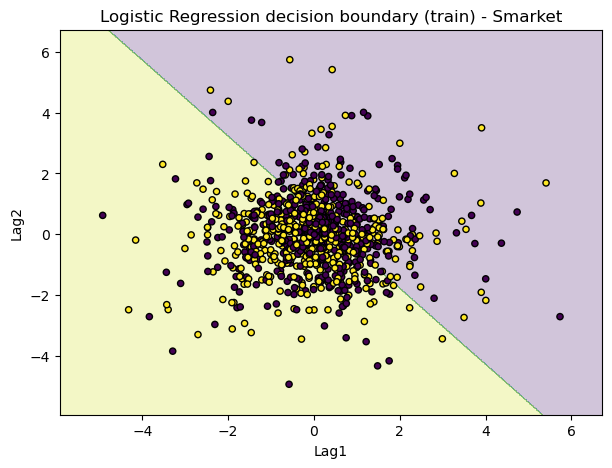

(0.5595238095238095,
 array([[ 35,  76],
        [ 35, 106]]))

In [21]:
# Fit logistic regression
logit = LogisticRegression(solver='lbfgs')
logit.fit(X_train, y_train)

# Decision boundary on training set
plot_decision_boundary(logit, X_train, y_train,
                       title='Logistic Regression decision boundary (train) - Smarket',
                       xlabel='Lag1', ylabel='Lag2')

# Test performance
pred_test = logit.predict(X_test)
acc = accuracy_score(y_test, pred_test)
cm = confusion_matrix(y_test, pred_test)
acc, cm

Interpretation:
- Logistic regression is **discriminative**: it fits $P(y\mid x)$ directly.
- With only two lags, you’ll usually see a **linear** decision boundary.
- Accuracy here depends on how informative Lag1/Lag2 are for 2005.


---
# 2) LDA (Linear Discriminant Analysis)

LDA is **generative**. It assumes class-conditional Gaussians with a **shared covariance**:

$$
x\mid y=k \sim \mathcal{N}(\mu_k,\Sigma),\qquad P(y=k)=\pi_k.
$$

Using Bayes’ rule, the log-posterior is (up to constants):

$$
\delta_k(x)= x^\top\Sigma^{-1}\mu_k - \tfrac12 \mu_k^\top\Sigma^{-1}\mu_k + \log\pi_k.
$$

**Decision boundary** between classes is linear because $\Sigma$ is shared.


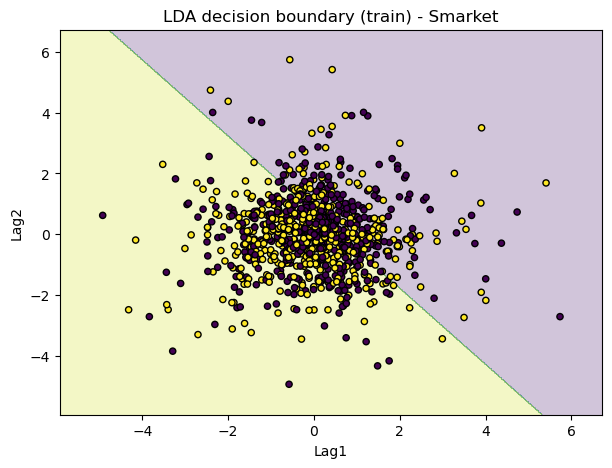

(0.5595238095238095,
 array([[ 35,  76],
        [ 35, 106]]))

In [22]:
# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

plot_decision_boundary(lda, X_train, y_train,
                       title='LDA decision boundary (train) - Smarket',
                       xlabel='Lag1', ylabel='Lag2')

pred_test = lda.predict(X_test)
acc = accuracy_score(y_test, pred_test)
cm = confusion_matrix(y_test, pred_test)
acc, cm

Why the boundary is linear:
- Under shared $\Sigma$, the quadratic term $x^\top\Sigma^{-1}x$ cancels when comparing classes.
- What remains is an affine function of $x$.


---
# 3) QDA (Quadratic Discriminant Analysis)

QDA keeps the Gaussian generative idea but lets each class have its **own covariance**:

$$
x\mid y=k \sim \mathcal{N}(\mu_k,\Sigma_k),\qquad P(y=k)=\pi_k.
$$

Discriminant score (up to constants):

$$
\delta_k(x)= -\tfrac12\log|\Sigma_k| -\tfrac12(x-\mu_k)^\top\Sigma_k^{-1}(x-\mu_k) + \log\pi_k.
$$

**Decision boundary** is quadratic because $\Sigma_k^{-1}$ depends on the class.


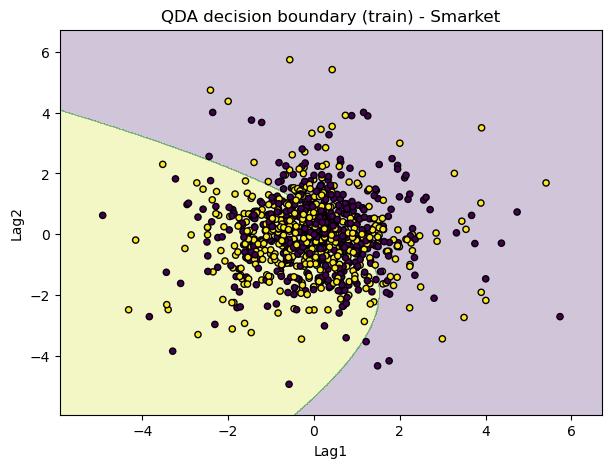

(0.5992063492063492,
 array([[ 30,  81],
        [ 20, 121]]))

In [23]:
# Fit QDA
qda = QuadraticDiscriminantAnalysis(reg_param=0.0)
qda.fit(X_train, y_train)

plot_decision_boundary(qda, X_train, y_train,
                       title='QDA decision boundary (train) - Smarket',
                       xlabel='Lag1', ylabel='Lag2')

pred_test = qda.predict(X_test)
acc = accuracy_score(y_test, pred_test)
cm = confusion_matrix(y_test, pred_test)
acc, cm

Notes:
- QDA is more flexible (curved boundaries) but estimates many more parameters.
- If you see warnings about singular covariance, that usually means **not enough data** or strong collinearity; regularization (`reg_param`) helps.


---
## Comparison on Smarket (test accuracy)
Let’s compare the three models side-by-side numerically.


In [24]:
models = {
    'Logistic Regression': logit,
    'LDA': lda,
    'QDA': qda,
}
rows = []
for name, m in models.items():
    pred = m.predict(X_test)
    rows.append({
        'model': name,
        'test_accuracy': accuracy_score(y_test, pred)
    })
pd.DataFrame(rows).sort_values('test_accuracy', ascending=False)

,model,test_accuracy
2,QDA,0.599206
0,Logistic Regression,0.559524
1,LDA,0.559524


---
# Multi-class prediction: Logistic (softmax) vs LDA vs QDA
To highlight the multi-class setting, we switch to **Iris (3 classes)** with two features so we can visualize decision regions.

## Multinomial logistic regression (softmax)

$$
P(y=k\mid x)=\frac{\exp(\beta_{k0}+\beta_k^\top x)}{\sum_{j=1}^K\exp(\beta_{j0}+\beta_j^\top x)}.
$$

Pairwise boundaries $P(y=k\mid x)=P(y=\ell\mid x)$ are still **linear** in $x$.


In [25]:
# Load iris and keep 2D features for plotting
iris = load_iris(as_frame=True)
df = iris.frame.copy()

# Use two features for clean 2D plots: petal length & petal width
feat = ['petal length (cm)', 'petal width (cm)']
X = df[feat].to_numpy()
y = df['target'].to_numpy()
target_names = iris.target_names

pd.DataFrame({'class': target_names, 'count': np.bincount(y)})

,class,count
0,setosa,50
1,versicolor,50
2,virginica,50


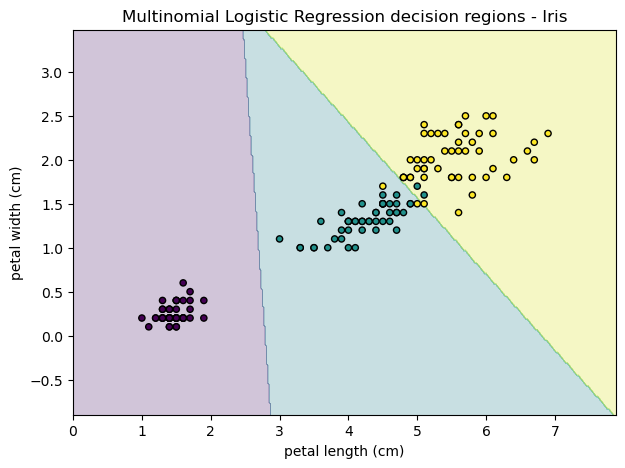

In [26]:
# Multinomial logistic regression
m_logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
m_logit.fit(X, y)
plot_decision_boundary(m_logit, X, y,
                       title='Multinomial Logistic Regression decision regions - Iris',
                       xlabel=feat[0], ylabel=feat[1])

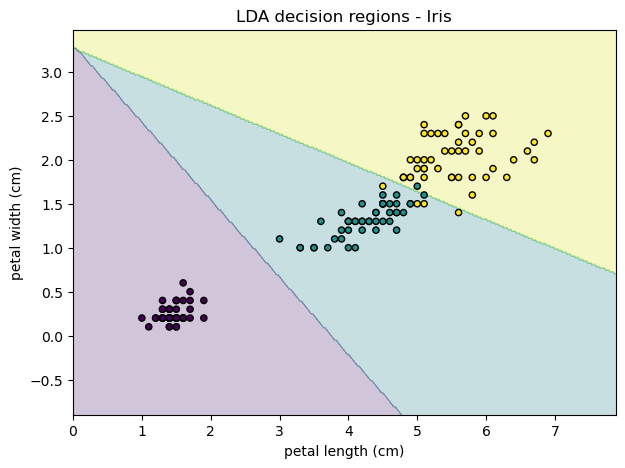

In [27]:
# LDA multi-class
m_lda = LinearDiscriminantAnalysis()
m_lda.fit(X, y)
plot_decision_boundary(m_lda, X, y,
                       title='LDA decision regions - Iris',
                       xlabel=feat[0], ylabel=feat[1])

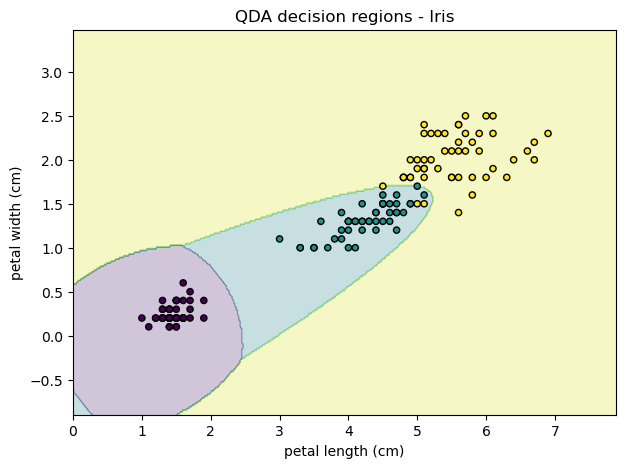

In [28]:
# QDA multi-class
m_qda = QuadraticDiscriminantAnalysis(reg_param=0.0)
m_qda.fit(X, y)
plot_decision_boundary(m_qda, X, y,
                       title='QDA decision regions - Iris',
                       xlabel=feat[0], ylabel=feat[1])

### Multi-class takeaways
- **Logistic regression (softmax)**: discriminative, linear boundaries (in original features).
- **LDA**: generative, linear boundaries from shared covariance.
- **QDA**: generative, curved boundaries from class-specific covariance.

In practice, QDA can overfit when $d$ is large relative to sample size, because it estimates one full covariance per class.


---
# Summary
- **complete separation**, the *unregularized* logistic regression MLE may not exist (coefficients blow up). **Regularization** makes the problem well-posed and yields finite estimates.
- **Logistic regression** models $P(y\mid x)$ directly (discriminative). With raw features, its decision boundary is **linear**.
- **LDA** models $p(x\mid y)$ as Gaussian with a **shared** covariance; Bayes rule yields **linear** decision boundaries.
- **QDA** allows **class-specific** covariances; the resulting boundaries are **quadratic** (curved), but it needs more data to estimate each covariance reliably.
- **Multi-class:** multinomial (softmax) logistic and LDA both give **linear** boundaries; QDA can produce **curved** regions.
